In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sp
from IPython.display import Image
import time
import pickle

Define functions:

In [3]:
def minfunc(beta):
    D_k = (Pr_k*N_k - beta*Pn_k*R_k)/np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)
    D_q = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(D_k))))
    return np.sqrt(np.mean(np.square(D_q)))

In [4]:
def minfunc0(beta):
    D_k0 = (Pr_k*N_k0 - beta*Pn_k*R_k)/np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)
    D_q0 = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(D_k0))))
    return np.sqrt(np.mean(np.square(D_q0)))

Analyze data:

In [5]:
Dirname = 'Simulated Data\Movment of +0.4 in y set2'
Set_size = 100 # Number of images in a set
ZeroMove_max = np.zeros(Set_size, dtype=float) # allocate memoty for maximal zero movement detection value
FiniteMove_max = np.zeros(Set_size, dtype=float) # allocate memoty for maximal finite movement detection value

for ind in range(1,Set_size+1):    
    with open(Dirname + '\\' + str(ind) + '.pickle') as f:
        N_q,R_q,Pn_q,Pr_q,q,sigma_n,N_q0,N = pickle.load(f)
    
    # Move to k-space
    sigma_r = sigma_n # Noise Stdv is the same for both images
    N_k = np.fft.fftshift(np.fft.fft2(N_q))
    N_k0 = np.fft.fftshift(np.fft.fft2(N_q0))
    R_k = np.fft.fftshift(np.fft.fft2(R_q))
    Pn_k = np.fft.fftshift(np.fft.fft2(Pn_q))
    Pr_k = np.fft.fftshift(np.fft.fft2(Pr_q))
    
    # *******Compute S for zero movement********
    
    betaOpt0 = sp.fmin(minfunc0, x0 = 2) # Find beta for zero movement
    
    D_k0 = lambda beta: (Pr_k*N_k0 - beta*Pn_k*R_k)/np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) 
                                                      + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)

    D_q0 = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(D_k0(betaOpt0)))))
    
    Fn = 1.2 # New flux
    FD = lambda beta: Fn/np.sqrt(sigma_n**2 + beta**2*sigma_r**2) # Difference image PSF normalization
    PD_k = lambda beta: Fn*Pr_k*Pn_k/(FD(beta)*np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)) # Difference image PSF 

    # Create M matrix
    k = np.linspace(-np.pi,np.pi-2*np.pi/N,N)
    kx, ky = np.meshgrid(k,k)
    dq = np.arange(-30,30,0.4)

    i = 0
    S0 = np.zeros((len(dq),N,N))
    for l in dq:

        M = np.exp(-1j*(kx*0 + ky*l))-1
        S_q = lambda beta: np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(FD(beta)*D_k0(beta)*PD_k(beta).conj()*M.conj()))))
        S0[i] = S_q(betaOpt0)
        i = i+1
    
    S0max = np.amax(np.amax(S0,axis=1), axis=1) # Vector of maximal pixel value for each dq
    std0 = np.std(S0[np.argmax(S0max),:,:]) # Stdev of the S0 image with maximal pixel value 
    S0max = S0max/std0 # normlization
    ZeroMove_max[ind-1] = np.max(S0max)
    # *******Compute S for finite movement********
    
    betaOpt = sp.fmin(minfunc, x0 = 2) # Find beta for finite movement
    
    D_k = lambda beta: (Pr_k*N_k - beta*Pn_k*R_k)/np.sqrt(sigma_n**2*np.square(np.abs(Pr_k)) 
                                                      + beta**2*sigma_r**2*np.square(np.abs(Pn_k))+1e-50)

    D_q = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(D_k(betaOpt)))))
    
    i = 0
    S = np.zeros((len(dq),N,N))
    for l in dq:

        M = np.exp(-1j*(kx*0 + ky*l))-1

        S_q = lambda beta: np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(FD(beta)*D_k(beta)*PD_k(beta).conj()*M.conj()))))
        S[i] = S_q(betaOpt)
        i = i+1
    Smax = np.amax(np.amax(S,axis=1), axis=1)/std0
    FiniteMove_max[ind-1] = np.max(Smax)

Optimization terminated successfully.
         Current function value: 0.999367
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.998395
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.000474
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 1.000992
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.000776
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.001047
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.999200
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.999677
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.998908
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.999457
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.000397
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.000350
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.000199
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.000798
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 1.001006
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.002872
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.999448
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 1.000067
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 1.002829
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.002671
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.998426
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 1.000173
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.998767
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.998822
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.000553
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.001024
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 1.001045
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 1.001333
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

Save results:

In [6]:
with open(Dirname + '\\' + 'results1.pickle', 'w') as f:
    pickle.dump([ZeroMove_max,FiniteMove_max], f)

Load results:

In [7]:
with open('Simulated Data\Movment of +0.4 in y set2\\results1.pickle') as f:
    ZeroMove_max,FiniteMove_max = pickle.load(f)

Successful detections:

<IPython.core.display.Javascript object>


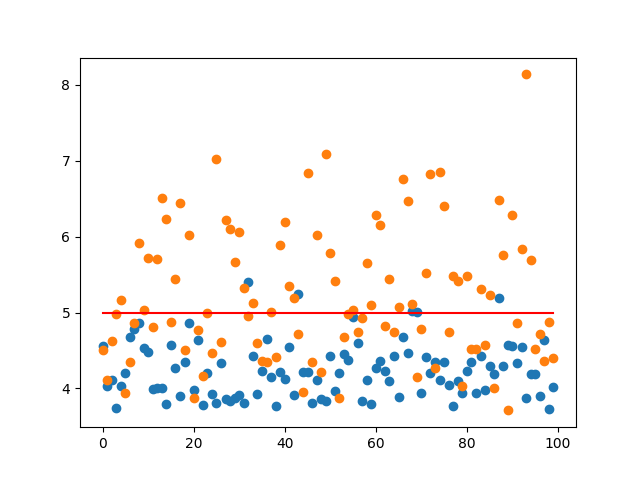

Number of successful detections = 52
Successful detections fraction = 0.52000000000000002
--------------------------------------
Number of false positives = 5
false positive fraction = 0.050000000000000003


In [8]:
eta = 5 # Define detection threshold for Dq=0.4
# eta = 7 # Define detection threshold for Dq=0.8

plt.figure()
plt.plot(ZeroMove_max,'o')
plt.plot(FiniteMove_max,'o')
plt.plot(eta*(np.ones(len(FiniteMove_max))),'r')

print 'Number of successful detections = %r' %np.sum(FiniteMove_max>eta)
print 'Successful detections fraction = %r' %(np.sum(FiniteMove_max>eta)/float(len(FiniteMove_max)))

print '--------------------------------------'

print 'Number of false positives = %r' %np.sum(ZeroMove_max>eta)
print 'false positive fraction = %r' %(np.sum(ZeroMove_max>eta)/float(len(ZeroMove_max)))